<a href="https://colab.research.google.com/github/hritiksth764/END-COURSE-SESSION-4.0-/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash 

python -m spacy download en
python -m spacy download fr


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-py3-none-any.whl size=14727025 sha256=fb63a777b4018a3674f7c722b5ecf9049b997367ac12a8e45530abf8ad87f36e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6003scpr/wheels/c9/a6/ea/0778337c34660027ee67ef3a91fb9d3600b76777a912ea1c24
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


In [2]:
!pip install torchtext

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IWSLT2016
from typing import Iterable, List

import spacy
import numpy as np

import random
import math
import time




In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
SRC_LANGUAGE = 'fr'
TGT_LANGUAGE = 'en'

In [6]:
# place-holder directories
token_transform = {}
vocab_transform = {}

In [7]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='fr')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en')

In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])



In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure that tokens are in the or4der of their indices to properly insert them in Vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [10]:
# Filter out samples with large sequence length... otherwise you need too much RAM.. system crash.
# Dataset too big... read every offset-th sample
def filter_function(unfiltered_dataset, offset=1):
    output_list = []
    count = 0
    for sample in unfiltered_dataset:
      count+= 1
      if count%offset == 0 and len(sample[0].strip().split(' ')) < 100 and len(sample[1].strip().split(' ')) < 100:
        output_list.append(sample)
    return output_list

In [11]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # training data iterator
  # print(type(IWSLT2016(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))))
  train_iter = filter_function(IWSLT2016(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)), 4)
  # create torchtext's vocab object
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                  min_freq=1,
                                                  specials = special_symbols,
                                                  special_first=True
                                                  )

100%|██████████| 188M/188M [00:01<00:00, 167MB/s]


In [12]:
# We need to set UNK_IDX as the defaul index. This index is requtrned when the token
# is not found. If this is NOT set, it throws RUNTIMEERROR when the queried token
# is not found in the vocabulary

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 175):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [16]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [17]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 175):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [21]:
BATCH_SIZE = 32
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [22]:
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,329,480 trainable parameters


In [24]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


model.apply(initialize_weights);

In [25]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [26]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [27]:
######################################################################
# Collation
# ---------
#   
# As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
# We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
# defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
# can be fed directly into our model.   
#


from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    # print(src_batch.dtype, src_batch.shape, tgt_batch.dtype, tgt_batch.shape)
    return src_batch, tgt_batch

In [28]:
######################################################################
# Let's define training and evaluation loop that will be called for each 
# epoch.
#

from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = filter_function(IWSLT2016(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)), 4)
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        # print(src.shape)
        # print(tgt.shape)
        # print(tgt[:,:-1].shape)

        optimizer.zero_grad()
        output, _ = model(src, tgt[:,:-1]) #[:,:-1])

        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output = output[1:].view(-1, output.shape[-1])
        # tgt = tgt[1:].reshape(-1) #tgt[:,:-1][1:].reshape(-1)
        loss = loss_fn(output, tgt)
        loss.backward()
        clip = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = filter_function(IWSLT2016(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)), 4)
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)[:,:-1]

        output, _ = model(src, tgt[:,:-1])
            
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output = output[1:].view(-1, output.shape[-1])
        # tgt = tgt[1:].reshape(-1)
        loss = loss_fn(output, tgt)
        losses += loss.item()

    return losses / len(val_dataloader)


In [29]:
from timeit import default_timer as timer
NUM_EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    end_time = timer()
    val_loss = evaluate(model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train PPL: {math.exp(train_loss):7.3f} | Val loss: {val_loss:.3f}, Val. PPL: {math.exp(val_loss):7.3f} | "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch: 1, Train loss: 5.147, Train PPL: 171.896 | Val loss: 4.567, Val. PPL:  96.212 | Epoch time = 156.231s
Epoch: 2, Train loss: 4.196, Train PPL:  66.392 | Val loss: 3.982, Val. PPL:  53.628 | Epoch time = 158.885s
Epoch: 3, Train loss: 3.516, Train PPL:  33.652 | Val loss: 3.683, Val. PPL:  39.766 | Epoch time = 159.921s
Epoch: 4, Train loss: 2.999, Train PPL:  20.059 | Val loss: 3.535, Val. PPL:  34.280 | Epoch time = 160.512s
Epoch: 5, Train loss: 2.587, Train PPL:  13.289 | Val loss: 3.456, Val. PPL:  31.703 | Epoch time = 160.668s
Epoch: 6, Train loss: 2.252, Train PPL:   9.509 | Val loss: 3.550, Val. PPL:  34.819 | Epoch time = 160.574s
Epoch: 7, Train loss: 1.979, Train PPL:   7.239 | Val loss: 3.695, Val. PPL:  40.241 | Epoch time = 160.607s
Epoch: 8, Train loss: 1.773, Train PPL:   5.887 | Val loss: 3.675, Val. PPL:  39.444 | Epoch time = 160.579s
Epoch: 9, Train loss: 1.609, Train PPL:   4.995 | Val loss: 3.670, Val. PPL:  39.267 | Epoch time = 160.702s
Epoch: 10, Train lo

In [30]:
test_loss = evaluate(model)

In [31]:
def translate_sentence(sentence, src_field, trg_field, model, device, init_token, eos_token, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)
    else:
        src_tensor = text_transform[TGT_LANGUAGE](sentence).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field[init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field[eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.get_itos()[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [33]:
data_iter = filter_function(IWSLT2016(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)), 4)
c = 0

print("*"*40)
print("French to English Translations:-")
print("*"*40)
for src, trg in list(data_iter):
  print('\n')
  print(f"{c+1}) French Sentence: {src}")
  print(f"Target English Sentence: {trg}")
  
  pred, attention = translate_sentence(src, vocab_transform[SRC_LANGUAGE], vocab_transform[TGT_LANGUAGE], model, device, '<bos>', '<eos>')

  print(f"Predicted English Sentence: {' '.join(pred[:-1])}")
  # print("Attention Map: ")
  # display_attention(src, pred, attention)

  c += 1
  if c >= 10:
    break

****************************************
French to English Translations:-
****************************************


1) French Sentence: Lorsqu'Alex est entrée pour sa première séance, elle portait un jean et un grand top trop large, elle s'est laissée tomber sur le canapé de mon bureau, a enlevé ses chaussures et m'a dit qu'elle était ici pour parler de problèmes de garçons.

Target English Sentence: Now Alex walked into her first session wearing jeans and a big slouchy top, and she dropped onto the couch in my office and kicked off her flats and told me she was there to talk about guy problems.

Predicted English Sentence: When Alex is in his first lady , she wore a party and a large lady , she was getting too large on my office , and she said , she said , " stressed her office , she said to talk about some of the problems that she


2) French Sentence: Je pensais pouvoir gérer ça.

Target English Sentence: This I thought I could handle.

Predicted English Sentence: I thought I could

****************************************
French to English Translations:-
****************************************


1) French Sentence: Lorsqu'Alex est entrée pour sa première séance, elle portait un jean et un grand top trop large, elle s'est laissée tomber sur le canapé de mon bureau, a enlevé ses chaussures et m'a dit qu'elle était ici pour parler de problèmes de garçons.

Target English Sentence: Now Alex walked into her first session wearing jeans and a big slouchy top, and she dropped onto the couch in my office and kicked off her flats and told me she was there to talk about guy problems.

Predicted English Sentence: When Alex is in his first lady , she wore a party and a large lady , she was getting too large on my office , and she said , she said , " stressed her office , she said to talk about some of the problems that she
Attention Map: 


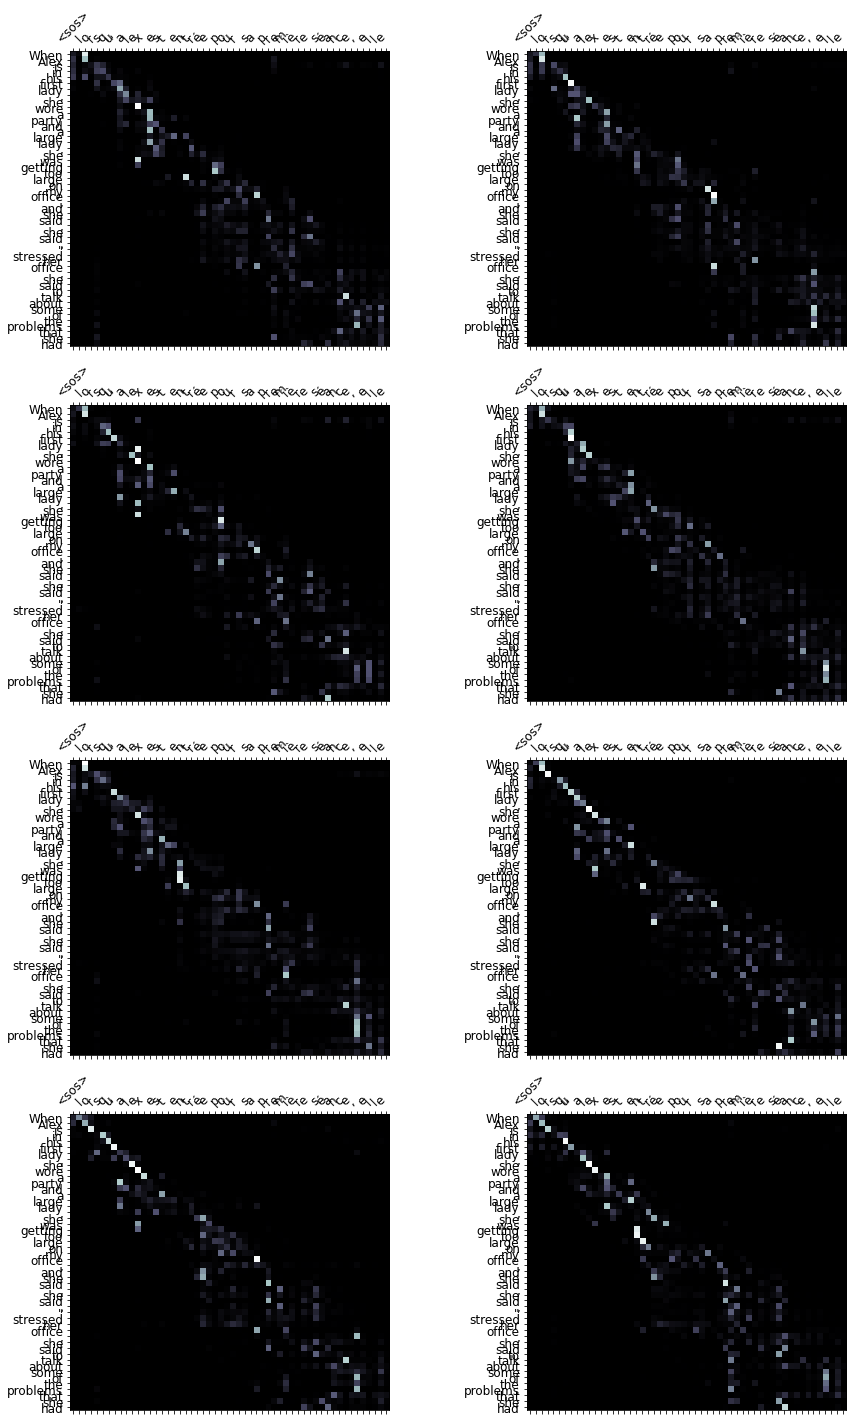



2) French Sentence: Je pensais pouvoir gérer ça.

Target English Sentence: This I thought I could handle.

Predicted English Sentence: I thought I could deal with this .
Attention Map: 


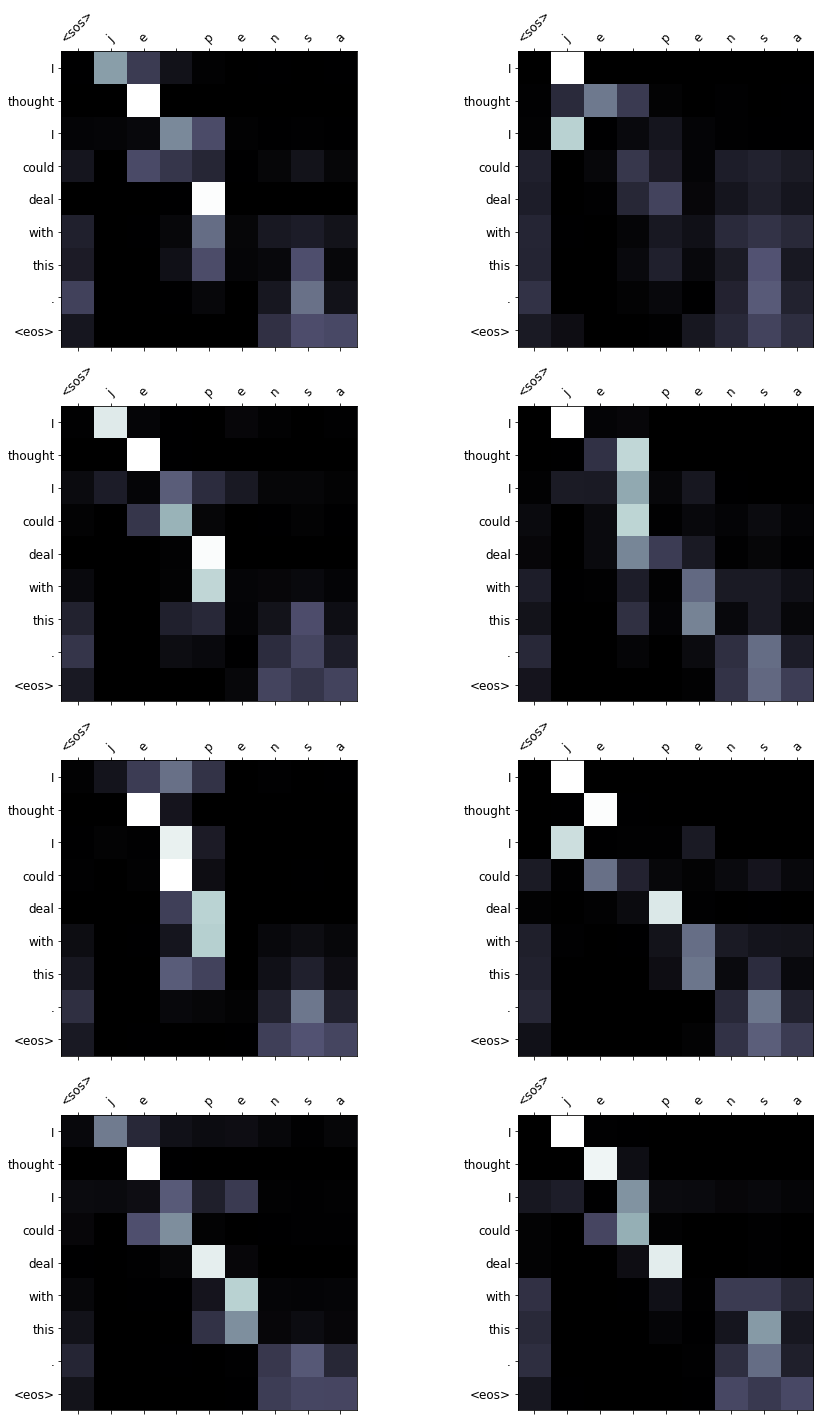



3) French Sentence: Le travail arrive plus tard, le mariage arrive plus tard, les enfants arrivent plus tard, même la mort arrive plus tard.

Target English Sentence: Work happened later, marriage happened later, kids happened later, even death happened later.

Predicted English Sentence: The work happens later , marriage , day is coming later , even death , even though death will get over .
Attention Map: 


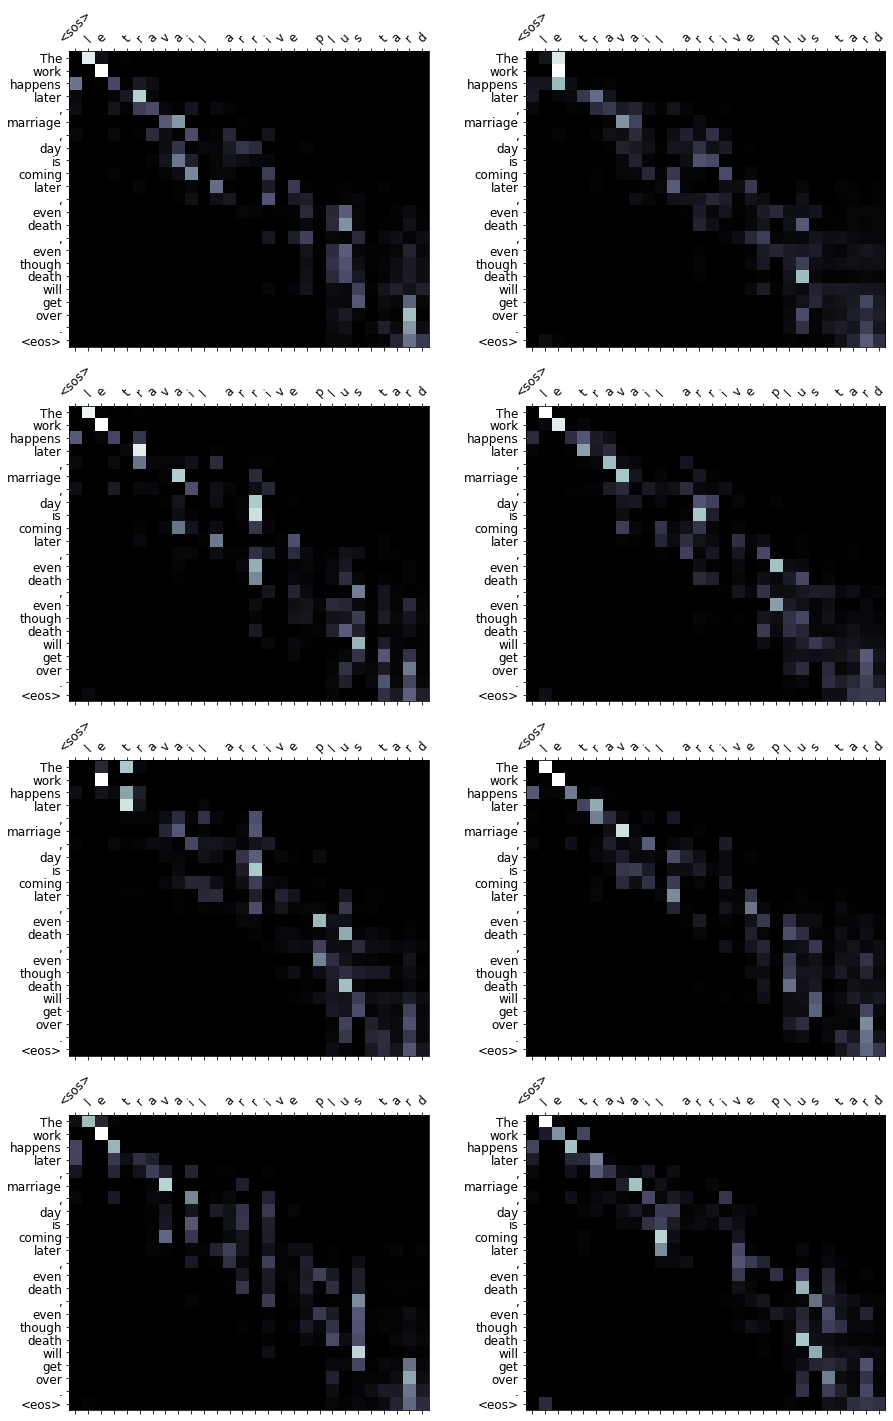



4) French Sentence: J'ai dit, « Oui, elle sort avec des idiots, elle couche avec un crétin, mais ce n'est pas qu'elle va l'épouser. »

Target English Sentence: I said, "Sure, she's dating down, she's sleeping with a knucklehead, but it's not like she's going to marry the guy."

Predicted English Sentence: I said , " Yeah , it 's coming out with the feathers of the product , but it 's not what it 's going to marry on . "
Attention Map: 


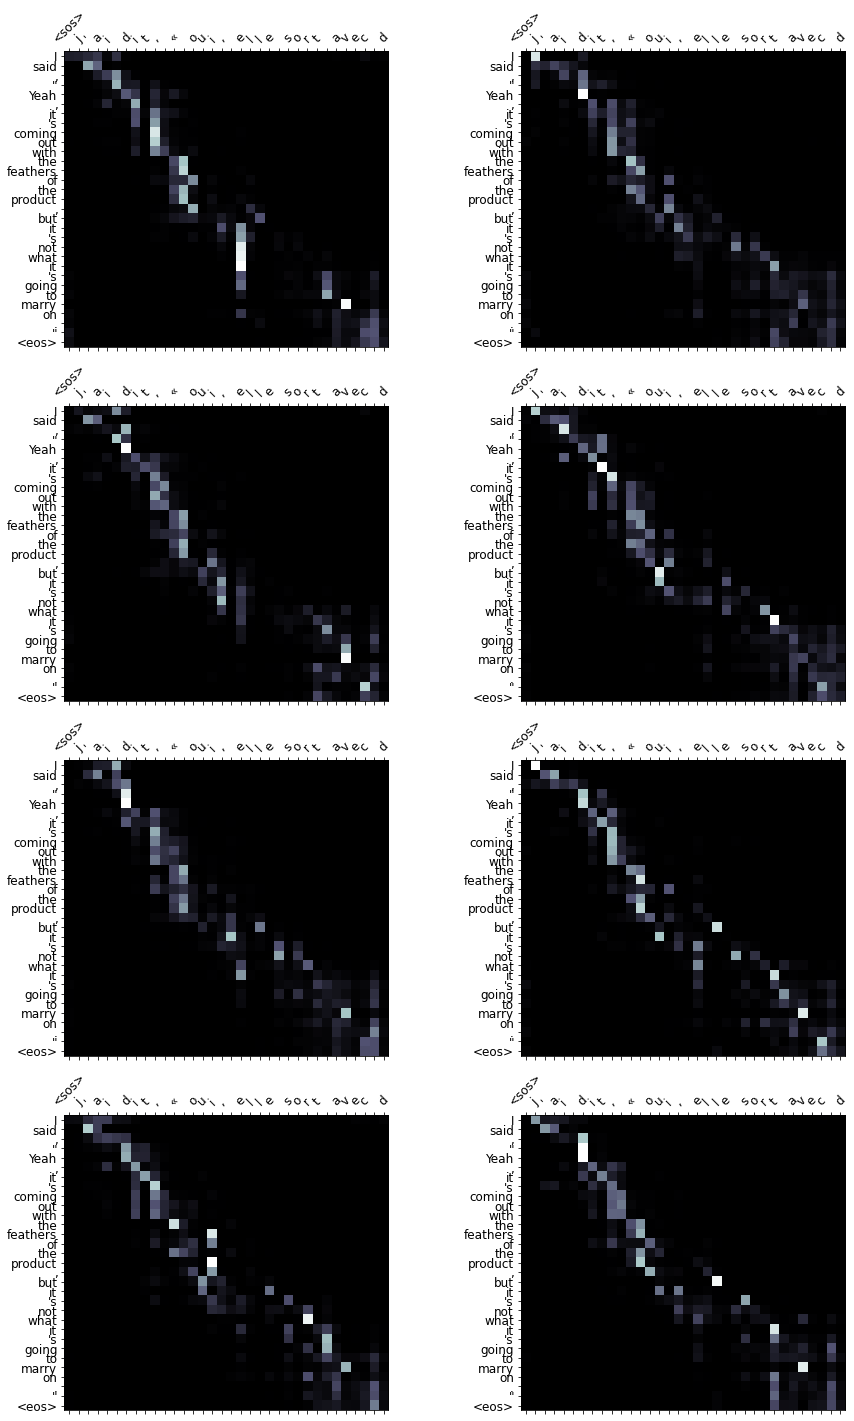



5) French Sentence: C'est le moment où j'ai réalisé que la trentaine n'est pas la nouvelle vingtaine.

Target English Sentence: That was the moment I realized, 30 is not the new 20.

Predicted English Sentence: This is the moment that I realized that the window is not the new thing .
Attention Map: 


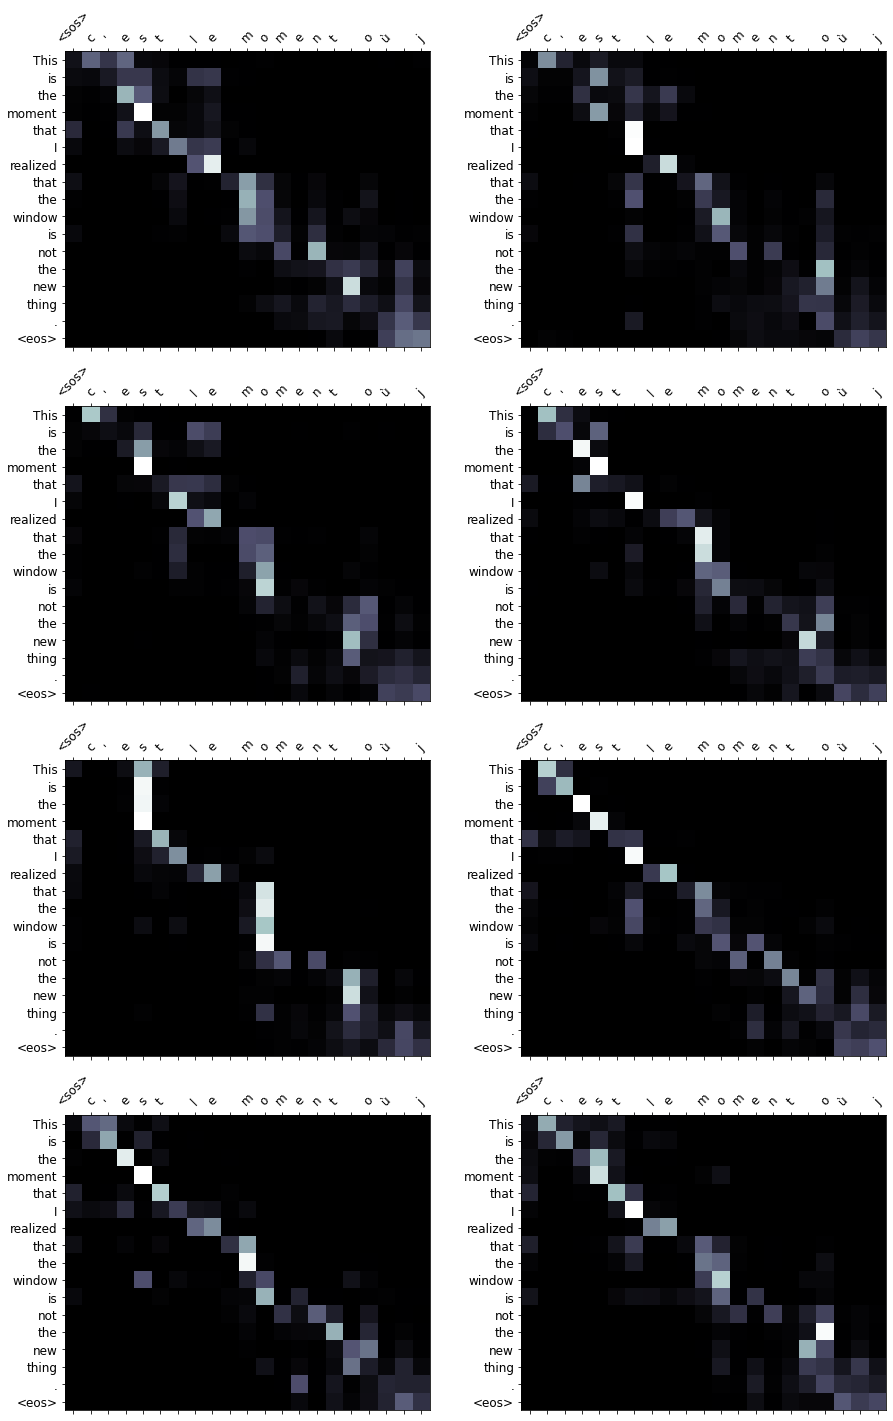

In [34]:
data_iter = filter_function(IWSLT2016(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)), 4)
c = 0

print("*"*40)
print("French to English Translations:-")
print("*"*40)
for src, trg in list(data_iter):
  print('\n')
  print(f"{c+1}) French Sentence: {src}")
  print(f"Target English Sentence: {trg}")
  
  pred, attention = translate_sentence(src, vocab_transform[SRC_LANGUAGE], vocab_transform[TGT_LANGUAGE], model, device, '<bos>', '<eos>')

  print(f"Predicted English Sentence: {' '.join(pred[:-1])}")
  print("Attention Map: ")
  display_attention(src, pred, attention)

  c += 1
  if c >= 5:
    break